In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import signal
from scipy import special

import numpy as np
import pandas as pd

import os
import itertools as it
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 3).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

In [2]:
src = '../hpcc/'
csrc = src + 'clean/'
rsrc = src + 'rotated/'
wsrc = src + 'watershed/'

dst = '../hpcc/topology/'

In [3]:
idname = '2014SBa'

rownum = 1
treenum = 36
nutnum = 1

bname = idname + '_R{}_T{}'.format(rownum, treenum)
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(csrc + bname + '/' + fname + '.tif')

bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
bimg = bimg.astype(float).ravel()

orig_datapoints = np.asarray(np.nonzero(border))
flat_datapoints = np.flatnonzero(border).astype(np.uint64)
print(orig_datapoints.shape)
print(flat_datapoints.shape)

2014SBa_R1_T36_001
(3, 997658)
(997658,)


# Complexify

In [4]:
mask = np.zeros(border.size, dtype=np.uint64)
mask[flat_datapoints] = flat_datapoints

In [5]:
edges, faces, cubes = wnut.complexify(flat_datapoints, mask, img.shape)

nv = len(flat_datapoints)
ne = len(edges)
nf = len(faces)
nc = len(cubes)

print('Verts:\t',nv)
print('Edges:\t',ne)
print('Faces:\t',nf)
print('Cubes:\t',nc)
print('\nEC:\t',nv-ne+nf-nc)

Verts:	 997658
Edges:	 1996728
Faces:	 1000496
Cubes:	 997658

EC:	 2


# Rotate

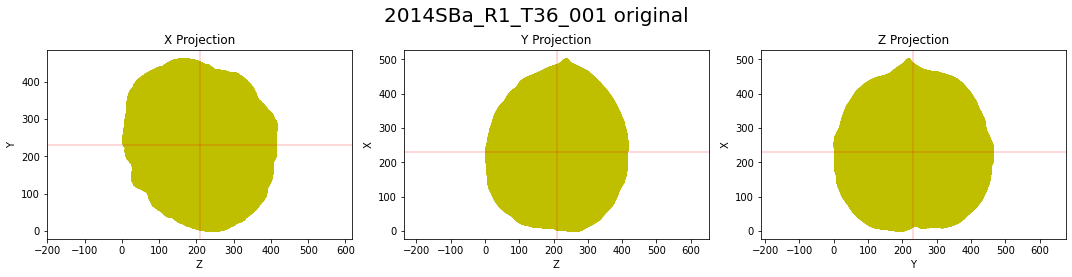

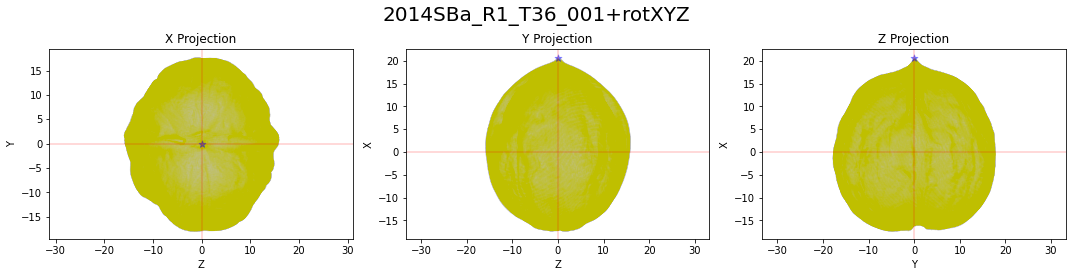

In [29]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, _, _ = data[13]
tipvox = data[14]
rtipvox = data[15]
tipvox[0] *= 1 + (-2*rotX)

coords = resol*(rotxyz @ (orig_datapoints - wmean.reshape(-1,1)))

fig, ax = wnut.plot_3Dprojections(orig_datapoints, fname + ' original', alpha=1, writefig=False, origin=wmean);
fig, ax = wnut.plot_3Dprojections(coords, fname + '+rotXYZ', alpha=0.01, writefig=False);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b')
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b')
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b');

# Direction

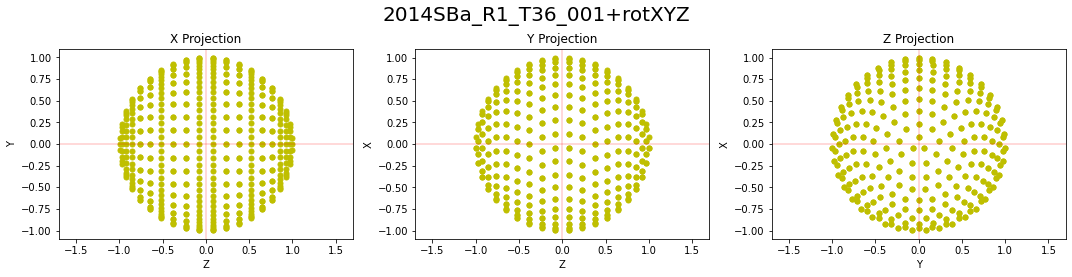

In [125]:
reload(wnut)
#udirections = wnut.regular_directions(150)
fig, ax = wnut.plot_3Dprojections(udirections.T, fname + '+rotXYZ', markersize=100);

In [124]:
for ll in [50,100,150,200,300,500]:
    udirections = wnut.regular_directions(ll)
    filename = dst + 'uniform_directions_{:03d}.csv'.format(len(udirections))
    print(filename)
    np.savetxt(filename, udirections, delimiter=',')

../hpcc/topology/uniform_directions_0050.csv
../hpcc/topology/uniform_directions_0100.csv
../hpcc/topology/uniform_directions_0150.csv
../hpcc/topology/uniform_directions_0200.csv
../hpcc/topology/uniform_directions_0300.csv
../hpcc/topology/uniform_directions_0500.csv


In [128]:
direction_files = sorted(glob.glob(dst + '*.csv'))
direction_files

['../hpcc/topology/uniform_directions_0050.csv',
 '../hpcc/topology/uniform_directions_0100.csv',
 '../hpcc/topology/uniform_directions_0150.csv',
 '../hpcc/topology/uniform_directions_0200.csv',
 '../hpcc/topology/uniform_directions_0300.csv',
 '../hpcc/topology/uniform_directions_0500.csv']

In [129]:
direction_file = direction_files[0]
udirections = np.loadtxt(direction_file, delimiter=',')

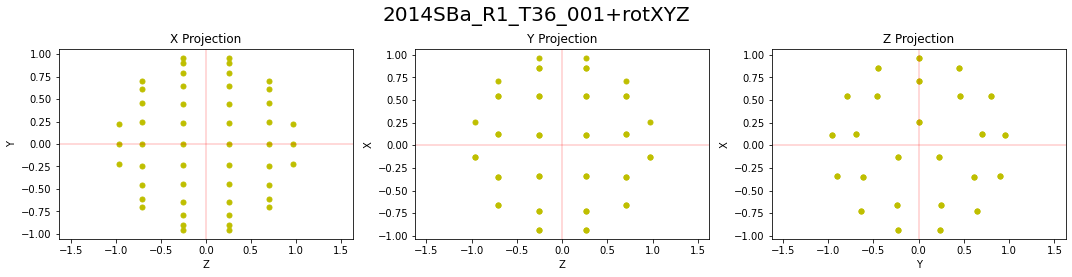

In [132]:
udirections.shape
fig, ax = wnut.plot_3Dprojections(udirections.T, fname + '+rotXYZ', markersize=100);

# ECC

In [104]:
direction = udirections[0]
print(direction)
heights = np.sum(coords*direction.reshape(-1,1), axis=0)


bimg[flat_datapoints] = heights

print(heights.shape, bimg.shape, sep='\t')
heights

[0.14231484 0.         0.98982144]
(997658,)	(97922025,)


array([-5.52335064, -5.59082393, -5.65829722, ...,  2.82757406,
        2.97277009,  2.9052968 ])

In [98]:
T = 32
minh = np.min(heights)
maxh = np.max(heights)
print('h_min = {:.2f},\th_max = {:.2f}'.format(minh, maxh))
buckets = [None for i in range(img.ndim+1)]
buckets[0], _ = np.histogram(heights, bins = T, range=(minh, maxh))
buckets[0]

h_min = -16.36,	h_max = 16.09


array([15632, 31144, 26224, 29104, 34479, 30957, 31209, 32411, 32964,
       32678, 33466, 32786, 32486, 31926, 32150, 31990, 32084, 32364,
       32218, 31799, 31427, 31590, 32434, 32159, 33267, 33787, 35394,
       37748, 33083, 34260, 34267,  8171])

In [99]:
buckets[1],_ = np.histogram(np.max(bimg[edges], axis=1), bins=T, range=(minh, maxh))
buckets[2],_ = np.histogram(np.max(bimg[faces], axis=1), bins=T, range=(minh, maxh))
buckets[3],_ = np.histogram(np.max(bimg[cubes], axis=1), bins=T, range=(minh, maxh))

In [100]:
ecc = buckets[0] - buckets[1] + buckets[2] - buckets[3]
ecc = np.cumsum(ecc)
print(len(ecc))
ecc

32


array([ 11, -22,  17, -20,   0,   0,   6,  -4,  -5,   2,  -1,   1,   3,
         0,   2,   1,   1,   1,   0,   3,  -2,   1,   0,  -2,  15,   5,
       -15, -19,  17, -68,   0,   2])

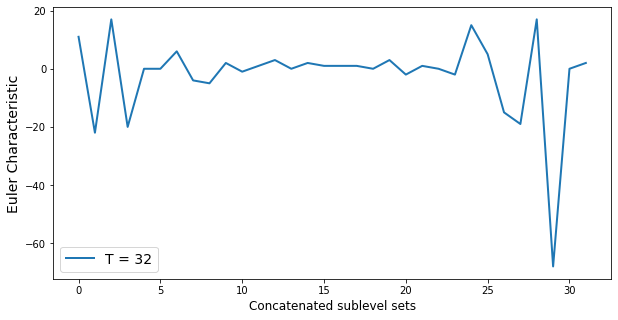

In [101]:
plt.figure(figsize = (10,5))
plt.plot(ecc, lw=2, label = 'T = {}'.format(T))
plt.ylabel('Euler Characteristic', fontsize=14)
plt.xlabel('Concatenated sublevel sets', fontsize=12)
plt.legend(fontsize=14);

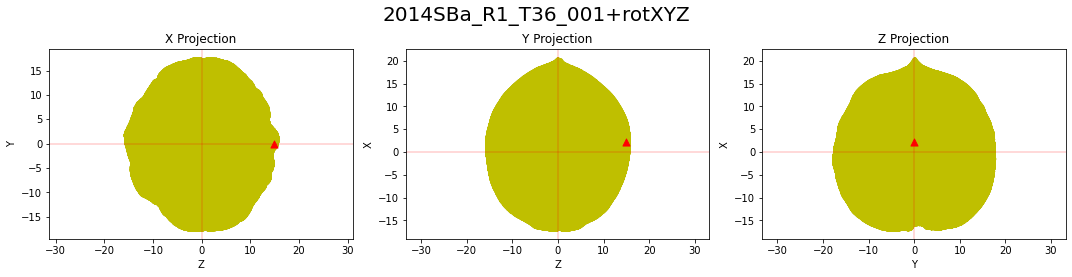

In [105]:
K = 15
kdirection = direction.copy()*K
fig, ax = wnut.plot_3Dprojections(coords, fname + '+rotXYZ', alpha=1, writefig=False);
ax[0].scatter(kdirection[2], kdirection[1], marker='^', s=50, c='r')
ax[1].scatter(kdirection[2], kdirection[0], marker='^', s=50, c='r')
ax[2].scatter(kdirection[1], kdirection[0], marker='^', s=50, c='r');

# ECT

In [112]:
T = 32
ect = np.zeros(T*len(udirections), dtype=int)
buckets = [None for i in range(img.ndim+1)]

for i in range(len(udirections)):
    direction = udirections[i]
    heights = np.sum(coords*direction.reshape(-1,1), axis=0)
    bimg[flat_datapoints] = heights

    T = 32
    minh = np.min(heights)
    maxh = np.max(heights)
    buckets[0], _ = np.histogram(heights, bins = T, range=(minh, maxh))
    buckets[1],_ = np.histogram(np.max(bimg[edges], axis=1), bins=T, range=(minh, maxh))
    buckets[2],_ = np.histogram(np.max(bimg[faces], axis=1), bins=T, range=(minh, maxh))
    buckets[3],_ = np.histogram(np.max(bimg[cubes], axis=1), bins=T, range=(minh, maxh))
    ecc = buckets[0] - buckets[1] + buckets[2] - buckets[3]
    ecc = np.cumsum(ecc)
    ect[i*T : (i+1)*T] = ecc

In [113]:
ect[:T]

array([-15,  13,  16,   4,  -3,   1,  -2,   2,   4,  -2,   2,   0,   2,
        -2,   2,   0,   1,   1,   2,  -1,  -3, -10,   9,   3,  12,   3,
        -5,  -9,   0,  -9,  -2,   2])

In [114]:
ect[T:2*T]

array([ 5,  5,  1,  2, -4, -3,  4,  3,  4, -3,  2,  1,  1,  2,  1,  2,  0,
        1,  1,  2,  1, -2,  1,  2, -1,  9, -5,  2, -7, -3,  2,  2])

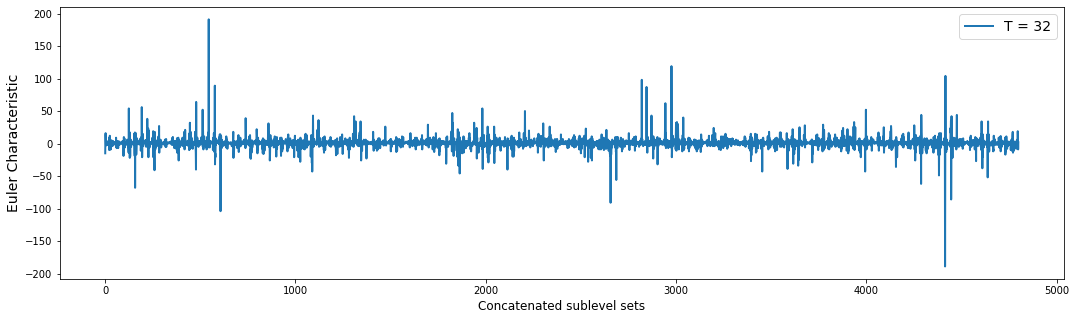

In [115]:
plt.figure(figsize = (18,5))
plt.plot(ect, lw=2, label = 'T = {}'.format(T))
plt.ylabel('Euler Characteristic', fontsize=14)
plt.xlabel('Concatenated sublevel sets', fontsize=12)
plt.legend(fontsize=14);

In [147]:
wdst = dst + bname + '/'
filename = wdst + fname + '_d{:04d}_t{:02d}.csv'.format(len(udirections), T)
print(filename)

foo = pd.DataFrame(ect).T
foo.to_csv(filename, header=False, index=False)

../hpcc/topology/2014SBa_R1_T36/2014SBa_R1_T36_001_d0050_t32.csv


In [148]:
foo

,0,1,2,3,4,5,6,7,8,9,...,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799
0,-15,13,16,4,-3,1,-2,2,4,-2,...,0,5,2,0,6,1,19,3,-9,2
